### Load libraries

In [19]:
from ast import literal_eval
from typing import Any, Callable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use("ggplot")

### Global config

In [20]:
QUESTION_CSV = "ipip-v2.2-agree_yes_disagree_no.csv"
RESPONSE_TAG = "agree_yes_disagree_no"

### Load questions

In [21]:
df = pd.read_csv(QUESTION_CSV).rename(columns={"front": "prompt_in_front"})

df.body = df.body.astype(bool)
df.prompt_in_front = df.prompt_in_front.astype(bool)
df.binarized = df.binarized.astype(bool)

df["n_classes"] = df.classes.str.count(",") + 1
df["baseline_acc"] = 1 / df.n_classes
df["baseline_loss"] = -np.log(df.baseline_acc)

assert len(df[(df.binarized & (df.n_classes != 2))]) == 0
assert len(df[(~df.binarized & (df.n_classes == 2))]) == 0

print(len(df))
df.head()

6640


,prompt,classes,answer_index,source_dataset,body,Q_id,prompt_in_front,binarized,n_classes,baseline_acc,baseline_loss
0,Select yes to agree or no to disagree with the...,"[' yes', ' no']",0,ipip,False,0,False,True,2,0.5,0.693147
1,Select no to disagree or yes to agree with the...,"[' yes', ' no']",0,ipip,False,0,False,True,2,0.5,0.693147
2,Select yes to agree or no to disagree with the...,"[' yes', ' no']",0,ipip,False,1,False,True,2,0.5,0.693147
3,Select no to disagree or yes to agree with the...,"[' yes', ' no']",0,ipip,False,1,False,True,2,0.5,0.693147
4,Select yes to agree or no to disagree with the...,"[' yes', ' no']",0,ipip,False,2,False,True,2,0.5,0.693147


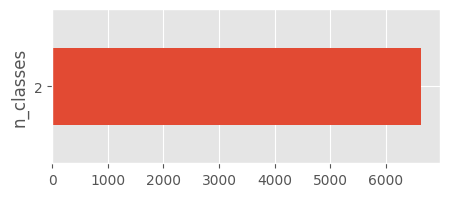

In [22]:
plt.figure(figsize=(5, 2))
df.groupby("n_classes").size().plot.barh();

### Load evaluation results

In [23]:
CSV_MAP: dict[str, str] = {
    "ada": "ada.csv",
    "babbage": "babbage.csv",
    "curie": "curie.csv",
    "davinci": "davinci.csv",
    "ada_rlhf": "text-ada-001.csv",
    "babbage_rlhf": "text-babbage-001.csv",
    "curie_rlhf": "text-curie-001.csv",
    "davinci_rlhf": "text-davinci-001.csv",
    "opt_125m": "opt-125m.csv",
    "opt_350m": "opt-350m.csv",
    "opt_1_3b": "opt-1.3b.csv",
    "opt_2_7b": "opt-2.7b.csv",
}

GPT3_SIZES = {
    # GPT-3 sizes are based on https://blog.eleuther.ai/gpt3-model-sizes/
    "ada": 350_000_000,
    "babbage": 1_300_000_000,
    "curie": 6_700_000_000,
    "davinci": 175_000_000_000,
}

GPT3_RLHF_SIZES = {
    "ada_rlhf": 350_000_000,
    "babbage_rlhf": 1_300_000_000,
    "curie_rlhf": 6_700_000_000,
    "davinci_rlhf": 175_000_000_000,
}

OPT_SIZES = {
    # opt sizes from their names
    "opt_125m": 125_000_000,
    "opt_350m": 350_000_000,
    "opt_1_3b": 1_300_000_000,
    "opt_2_7b": 2_700_000_000,
}

OGPT_SIZES = {"opt_125m": 125_000_000} | GPT3_SIZES

In [24]:
for model_name, path in CSV_MAP.items():
    cur_df = pd.read_csv(f"results_full/{RESPONSE_TAG}/" + path)

    assert len(df) == len(cur_df)

    # Parse probs
    probs_mat = np.array([literal_eval(x) for x in cur_df.probs])
    for i in range(probs_mat.shape[1]):
        df[f"prob_{model_name}_{i}"] = probs_mat[:, i]
        df[f"pred_{model_name}"] = probs_mat.argmax(axis=1)

df.columns.sort_values()

Index(['Q_id', 'answer_index', 'baseline_acc', 'baseline_loss', 'binarized',
       'body', 'classes', 'n_classes', 'pred_ada', 'pred_ada_rlhf',
       'pred_babbage', 'pred_babbage_rlhf', 'pred_curie', 'pred_curie_rlhf',
       'pred_davinci', 'pred_davinci_rlhf', 'pred_opt_125m', 'pred_opt_1_3b',
       'pred_opt_2_7b', 'pred_opt_350m', 'prob_ada_0', 'prob_ada_1',
       'prob_ada_rlhf_0', 'prob_ada_rlhf_1', 'prob_babbage_0',
       'prob_babbage_1', 'prob_babbage_rlhf_0', 'prob_babbage_rlhf_1',
       'prob_curie_0', 'prob_curie_1', 'prob_curie_rlhf_0',
       'prob_curie_rlhf_1', 'prob_davinci_0', 'prob_davinci_1',
       'prob_davinci_rlhf_0', 'prob_davinci_rlhf_1', 'prob_opt_125m_0',
       'prob_opt_125m_1', 'prob_opt_1_3b_0', 'prob_opt_1_3b_1',
       'prob_opt_2_7b_0', 'prob_opt_2_7b_1', 'prob_opt_350m_0',
       'prob_opt_350m_1', 'prompt', 'prompt_in_front', 'source_dataset'],
      dtype='object')

### High level statistics about predictions

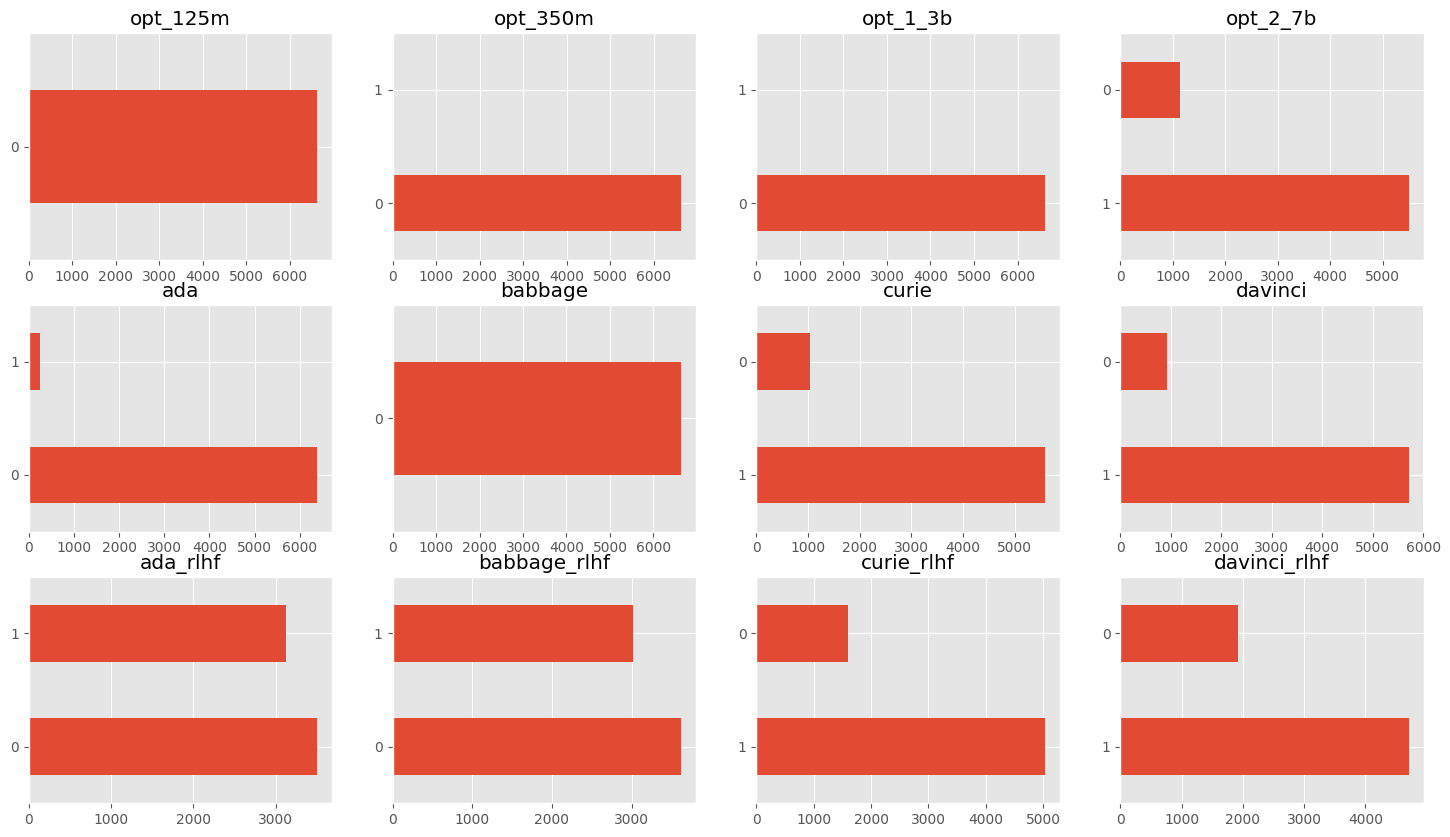

In [25]:
# Distribution of predictions
plt.figure(figsize=(18, 10))
for i, model_list in enumerate([OPT_SIZES.keys(), GPT3_SIZES.keys(), GPT3_RLHF_SIZES.keys()]):
    for j, model_name in enumerate(model_list):
        plt.subplot(3, 4, 4 * i + j + 1)
        df[f"pred_{model_name}"].value_counts().plot.barh();
        plt.title(model_name)

### Computes some stats for cherry-picking

In [26]:
df["opt_diff0"] = (df.prob_opt_125m_0 - df.prob_opt_2_7b_0)
df["gpt3_diff0"] = (df.prob_ada_0 - df.prob_davinci_0)
df["gpt3_rlhf_diff0"] = (df.prob_ada_rlhf_0 - df.prob_davinci_rlhf_0)

### Plotting code

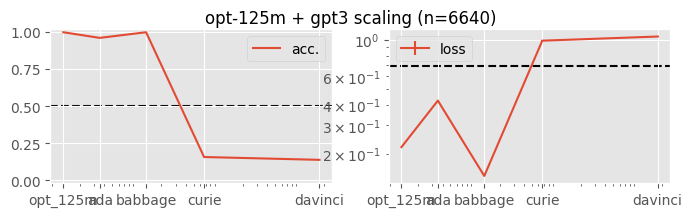

In [27]:
def gen_plots(
    df: pd.DataFrame,
    size_dict: dict[str, int],
    title: str = "",
):
    models = list(size_dict.keys())
    sizes = np.array(list(size_dict.values()))

    for model in models:
        arr = np.zeros((len(df)))
        arr = -np.log(df[f"prob_{model}_0"])
        arr[df.answer_index == 1] = -np.log(df[f"prob_{model}_1"][df.answer_index == 1])
        df[f"loss_{model}"] = arr

        df[f"correct_{model}"] = df[f"pred_{model}"] == df.answer_index

    losses = np.array([df[f"loss_{m}"].mean() for m in models])
    loss_errs = np.array([df[f"loss_{m}"].std() for m in models]) / np.sqrt(len(df))
    accs = np.array([df[f"correct_{m}"].mean() for m in models])
    # partial_accs = np.array([df[f"partial_credit_{m}"].mean() for m in models])

    plt.figure(figsize=(8, 2))
    plt.suptitle(title + f" (n={len(df)})")
    plt.tight_layout()

    def common_plot_setup(baseline: float):
        plt.axhline(
            baseline,
            linestyle="--",
            color="black",
            zorder=-1,
            # label="random baseline",
        )
        plt.xscale("log")
        # plt.xlabel("Model size")
        plt.xticks(sizes, models)
        plt.legend()

    # Acc
    plt.subplot(1, 2, 1)
    plt.plot(sizes, accs, label="acc.")
    plt.ylim(-0.02, 1.02)
    common_plot_setup(df.baseline_acc.mean())

    # Loss
    plt.subplot(1, 2, 2)
    plt.errorbar(sizes, losses, loss_errs, label="loss")
    plt.yscale("log")
    common_plot_setup(df.baseline_loss.mean())

gen_plots(df, OGPT_SIZES, title="opt-125m + gpt3 scaling")

In [28]:
def comprehensive_plot(df: pd.DataFrame, name: str):
    gen_plots(df, OPT_SIZES, title=f"{name} - OPT Scaling")
    gen_plots(df, GPT3_SIZES, title=f"{name} - GPT3 Scaling")
    gen_plots(df, GPT3_RLHF_SIZES, title=f"{name} - GPT3 (rlhf) Scaling")

### Babby's first inverse scaling attempt

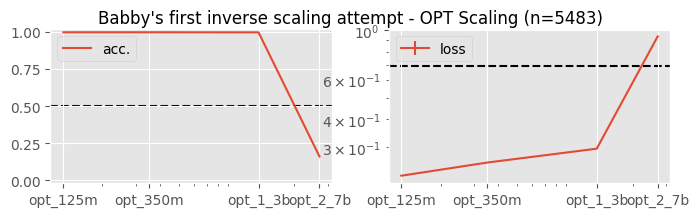

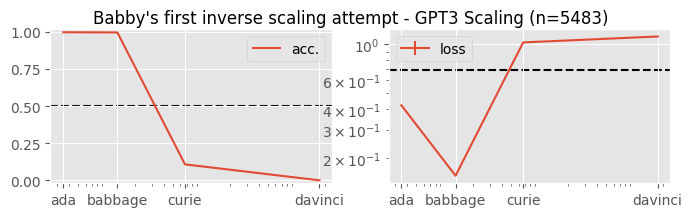

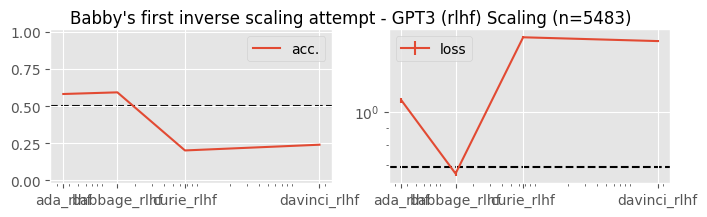

In [29]:
cdf = df.query("pred_ada != pred_davinci").copy()
cdf.answer_index = cdf.pred_ada
comprehensive_plot(cdf, "Babby's first inverse scaling attempt")

### Time for some real inverse scaling!

In [30]:
def top_n_with_score_fn(
    df: pd.DataFrame,
    n: int,
    score_fn: Callable[[pd.Series, int], np.ndarray],
    score_fn_name: str,
    weights: np.ndarray,
) -> pd.DataFrame:
    """
    Top n largest scores are returned.
    Adds column to the dataframe with the scores under column 'score_fn_name'
    """
    scores: list[float] = []
    answer_idxs: list[int] = []
    for i in range(len(df)):
        score0 = (score_fn(df.iloc[i], 0) * weights).sum() / weights.sum()
        score1 = (score_fn(df.iloc[i], 1) * weights).sum() / weights.sum()

        if score0 > score1:
            scores.append(score0)
            answer_idxs.append(0)
        else:
            scores.append(score1)
            answer_idxs.append(1)

    df[score_fn_name] = scores
    df.answer_index = answer_idxs
    thresh = df[score_fn_name].sort_values(ascending=False).iloc[n - 1]
    print(thresh)
    return df[score_fn_name] >= thresh


def strictly_decreasing(L):
    return all(x >= y for x, y in zip(L, L[1:]))


def strictly_increasing(L):
    return all(x <= y for x, y in zip(L, L[1:]))


def monotonic(L):
    return strictly_increasing(L) or strictly_decreasing(L)


def not_const(L):
    return not all(x == L[0] for x in L)


def score_acc(row: pd.Series, answer_idx: int) -> np.ndarray:
    opt_accs = [int(row[f"pred_{m}"] == answer_idx) for m in OPT_SIZES]
    gpt3_accs = [int(row[f"pred_{m}"] == answer_idx) for m in GPT3_SIZES]
    gpt3_rlhf_accs = [int(row[f"pred_{m}"] == answer_idx) for m in GPT3_RLHF_SIZES]

    opt_sd = strictly_decreasing(opt_accs)
    gpt3_sd = strictly_decreasing(gpt3_accs)
    gpt3_rlhf_sd = strictly_decreasing(gpt3_rlhf_accs)

    opt_nc = not_const(opt_accs)
    gpt3_nc = not_const(gpt3_accs)
    gpt3_rlhf_nc = not_const(gpt3_rlhf_accs)

    opt_score = opt_sd * opt_nc
    gpt3_score = gpt3_sd * gpt3_nc
    gpt3_rlhf_score = gpt3_rlhf_sd * gpt3_rlhf_nc

    return np.array([opt_score, gpt3_score, gpt3_rlhf_score])


def score_loss(row: pd.Series, answer_idx: int) -> np.ndarray:
    opt_probs = [row[f"prob_{m}_{answer_idx}"].mean() for m in OPT_SIZES]
    gpt3_probs = [row[f"prob_{m}_{answer_idx}"].mean() for m in GPT3_SIZES]
    gpt3_rlhf_probs = [row[f"prob_{m}_{answer_idx}"].mean() for m in GPT3_RLHF_SIZES]

    opt_losses = [-np.log(p) for p in opt_probs]
    gpt3_losses = [-np.log(p) for p in gpt3_probs]
    gpt3_rlhf_losses = [-np.log(p) for p in gpt3_rlhf_probs]

    opt_si = strictly_increasing(opt_losses)
    gpt3_si = strictly_increasing(gpt3_losses)
    gpt3_rlhf_si = strictly_increasing(gpt3_rlhf_losses)

    opt_diff = opt_losses[-1] - opt_losses[0]
    gpt3_diff = gpt3_losses[-1] - gpt3_losses[0]
    gpt3_rlhf_diff = gpt3_rlhf_losses[-1] - gpt3_rlhf_losses[0]

    return np.array([opt_diff, gpt3_diff, gpt3_rlhf_diff])

1.0


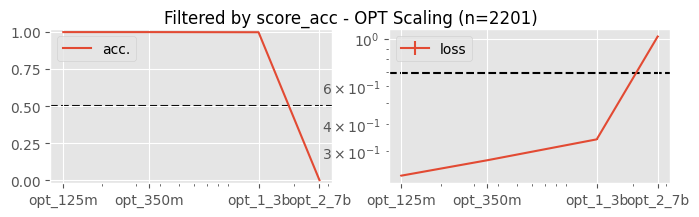

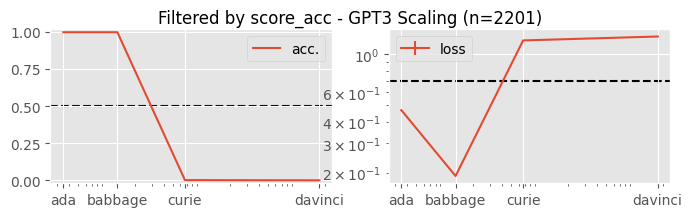

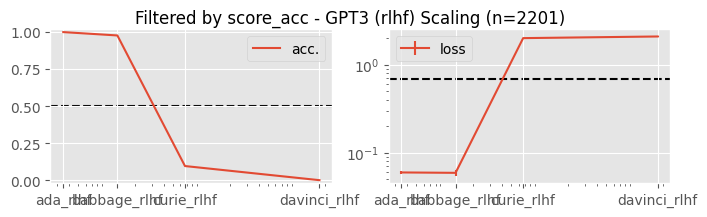

In [31]:
filt = top_n_with_score_fn(
    df,
    n=1000,
    score_fn=score_acc,
    score_fn_name="score_acc",
    weights=np.array([1, 1, 1]),
)
comprehensive_plot(df[filt].copy(), "Filtered by score_acc")
df[filt].copy()[["prompt", "answer_index", "classes"]].to_csv(
    f"cherry_exports/{RESPONSE_TAG}/for_acc.csv", index=False
)

1.3033026119242486


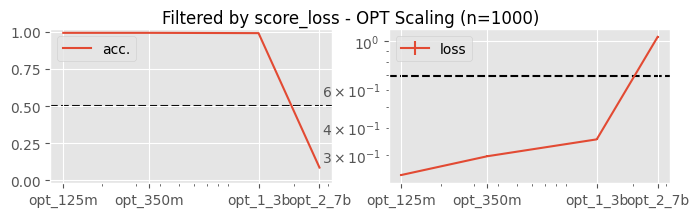

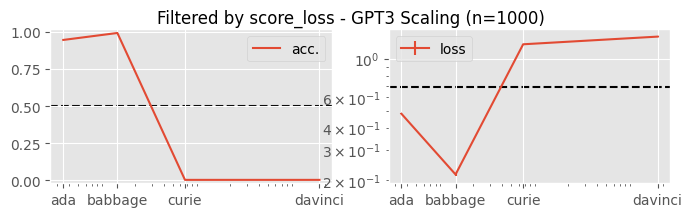

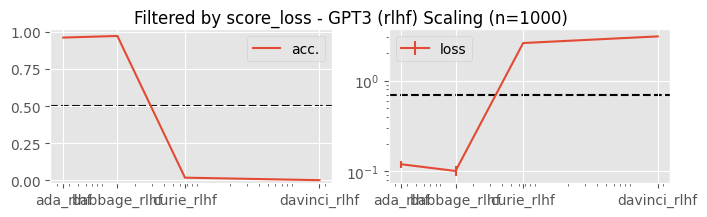

In [32]:
filt = top_n_with_score_fn(
    df,
    n=1000,
    score_fn=score_loss,
    score_fn_name="score_loss",
    weights=np.array([1, 1, 1]),
)
comprehensive_plot(df[filt].copy(), "Filtered by score_loss")
df[filt].copy()[["prompt", "answer_index", "classes"]].to_csv(
    f"cherry_exports/{RESPONSE_TAG}/for_loss.csv", index=False
)